In [1]:
import numpy as np
import pandas as pd

from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score, mean_absolute_error

import matplotlib.pyplot as plt
import seaborn as sns

plt.rcParams["figure.figsize"] = (16,10)

# Data cleaning

In [19]:
! ../data

/bin/sh: 1: ../data: Permission denied


In [127]:
data = pd.read_csv("../data/combined-data.csv")

/home/tuopelto/projects/singapore-hdb-price-prediction/env/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3063: DtypeWarning: Columns (9) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [128]:
data.shape

(101741, 16)

In [129]:
data = pd.read_csv("../data/combined-data.csv")

In [130]:
data.shape

(101741, 16)

In [131]:
data.head()

,month,town,flat_type,block,street_name,storey_range,floor_area_sqm,flat_model,lease_commence_date,remaining_lease,resale_price,mrt_station,Dist_to_station,noise,Park_dist,Bus_stop_dist
0,2015-01,ANG MO KIO,3 ROOM,174,ANG MO KIO AVE 4,07 TO 09,60.0,Improved,1986,70,255000.0,YIO CHU KANG MRT STATION,823.905301,69.9,217.561750,207.002126
1,2015-01,ANG MO KIO,3 ROOM,541,ANG MO KIO AVE 10,01 TO 03,68.0,New Generation,1981,65,275000.0,ANG MO KIO MRT STATION,808.563653,69.9,701.207107,59.866879
2,2015-01,ANG MO KIO,3 ROOM,163,ANG MO KIO AVE 4,01 TO 03,69.0,New Generation,1980,64,285000.0,YIO CHU KANG MRT STATION,1204.292767,69.9,239.915650,52.872599
3,2015-01,ANG MO KIO,3 ROOM,446,ANG MO KIO AVE 10,01 TO 03,68.0,New Generation,1979,63,290000.0,BISHAN MRT STATION,1121.890344,69.9,662.396968,10.290987
4,2015-01,ANG MO KIO,3 ROOM,557,ANG MO KIO AVE 10,07 TO 09,68.0,New Generation,1980,64,290000.0,BISHAN MRT STATION,1121.890344,69.9,662.396968,10.290987


In [132]:
data = data.dropna()

In [133]:
X = data.drop(columns=['resale_price'])
y = data['resale_price']

In [134]:
for c in X.columns:
    print(X[c].isna().sum())
    print(c, X[c].isnull().any())

0
month False
0
town False
0
flat_type False
0
block False
0
street_name False
0
storey_range False
0
floor_area_sqm False
0
flat_model False
0
lease_commence_date False
0
remaining_lease False
0
mrt_station False
0
Dist_to_station False
0
noise False
0
Park_dist False
0
Bus_stop_dist False


In [138]:
X['remaining_lease'] = X['remaining_lease'].apply(str)

In [140]:
# Categorical features to numeric features

for c in ['month', 'town', 'flat_type', 'block', 'storey_range', 'flat_model', 'mrt_station']:
    X = pd.concat([X, pd.get_dummies(X[c])], axis=1)


tmp = X['remaining_lease'].str.split(" ", n = 1, expand = True)
X["years_left"] = tmp[0]
X["years_left"] = pd.to_numeric(X["years_left"])

X = X.drop(columns=['month', 'town', 'flat_type', 'block', 'street_name', 'storey_range', 'flat_model', 'remaining_lease', 'mrt_station'])

In [141]:
X.head()

,floor_area_sqm,lease_commence_date,Dist_to_station,noise,Park_dist,Bus_stop_dist,2015-01,2015-02,2015-03,2015-04,...,TONGKANG LRT STATION,UBI MRT STATION,UPPER CHANGI MRT STATION,WOODLANDS MRT STATION,WOODLANDS SOUTH MRT STATION,WOODLEIGH MRT STATION,YEW TEE MRT STATION,YIO CHU KANG MRT STATION,YISHUN MRT STATION,years_left
0,60.0,1986,823.905301,69.9,217.561750,207.002126,1,0,0,0,...,0,0,0,0,0,0,0,1,0,70
1,68.0,1981,808.563653,69.9,701.207107,59.866879,1,0,0,0,...,0,0,0,0,0,0,0,0,0,65
2,69.0,1980,1204.292767,69.9,239.915650,52.872599,1,0,0,0,...,0,0,0,0,0,0,0,1,0,64
3,68.0,1979,1121.890344,69.9,662.396968,10.290987,1,0,0,0,...,0,0,0,0,0,0,0,0,0,63
4,68.0,1980,1121.890344,69.9,662.396968,10.290987,1,0,0,0,...,0,0,0,0,0,0,0,0,0,64


In [142]:
# Train, validation, and test split
train_split = 0.8
validation_split = 0.1
test_split = 0.1

train_X = X.iloc[:round(len(data)*train_split),:]
train_y = y.iloc[:round(len(data)*train_split)]

validation_X = X.iloc[round(len(data)*train_split):round(len(data)*train_split + len(data)*validation_split)]
validation_y = y.iloc[round(len(data)*train_split):round(len(data)*train_split + len(data)*validation_split)]


test_X = X.iloc[round(len(data)*train_split + len(data)*validation_split):,:]
test_y = y.iloc[round(len(data)*train_split + len(data)*validation_split):]

In [143]:
train_X.shape, train_y.shape, test_X.shape, test_y.shape

((61794, 2583), (61794,), (7724, 2583), (7724,))

# Modeling

In [144]:
model = RandomForestRegressor(verbose=3)
model.fit(train_X, train_y)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


building tree 1 of 100


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    3.8s remaining:    0.0s


building tree 2 of 100


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    7.6s remaining:    0.0s


building tree 3 of 100
building tree 4 of 100
building tree 5 of 100
building tree 6 of 100
building tree 7 of 100
building tree 8 of 100
building tree 9 of 100
building tree 10 of 100
building tree 11 of 100
building tree 12 of 100
building tree 13 of 100
building tree 14 of 100
building tree 15 of 100
building tree 16 of 100
building tree 17 of 100
building tree 18 of 100
building tree 19 of 100
building tree 20 of 100
building tree 21 of 100
building tree 22 of 100
building tree 23 of 100
building tree 24 of 100
building tree 25 of 100
building tree 26 of 100
building tree 27 of 100
building tree 28 of 100
building tree 29 of 100
building tree 30 of 100
building tree 31 of 100
building tree 32 of 100
building tree 33 of 100
building tree 34 of 100
building tree 35 of 100
building tree 36 of 100
building tree 37 of 100
building tree 38 of 100
building tree 39 of 100
building tree 40 of 100
building tree 41 of 100
building tree 42 of 100
building tree 43 of 100
building tree 44 of 100

[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:  6.2min finished


RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=100, n_jobs=None, oob_score=False,
                      random_state=None, verbose=3, warm_start=False)

# Validation

In [145]:
test_predictions = model.predict(test_X)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.3s finished


In [146]:
mae = mean_absolute_error(y_true=test_y, y_pred=test_predictions)
mae, mae/np.mean(test_y)

(28202.247211514514, 0.06593701454421216)

In [147]:
r2 = r2_score(y_true=test_y, y_pred=test_predictions)

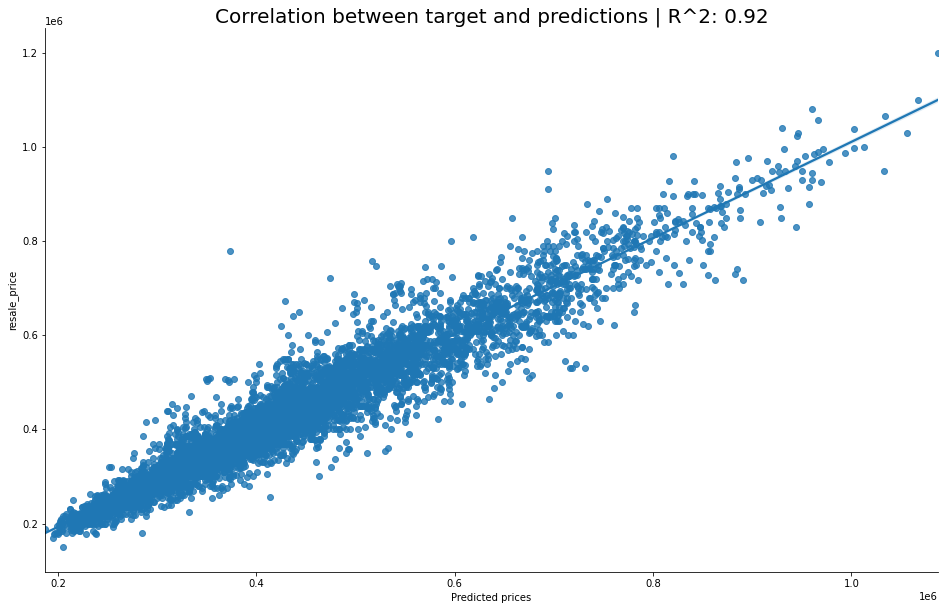

In [148]:
fig, ax = plt.subplots(figsize=(16, 10))

plt.title(f"Correlation between target and predictions | R^2: {round(r2, ndigits=2)}", fontsize=20)
plt.xlabel("Predicted prices")
plt.ylabel("Target prices")

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

sns.regplot(test_predictions, test_y)